In [2]:
import idx2numpy
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
import random as rnd
import numpy.typing as npt
import scipy.signal as sps

IMAGE_EDGE_SIZE = 28
PIXELS_PER_IMAGE = IMAGE_EDGE_SIZE ** 2
CLASSES_COUNT = 10
ITERATIONS = 500
LEARNING_RATE = 0.15

In [3]:
def one_hot(labels: npt.ArrayLike) -> npt.NDArray:
    """
    Converts a 1D array of labels (the ground truth) to 2D matrix of shape (10, labels.size) as a probability distribution, 
    where the corresponding row given by the label value has probability of 1.
    
    :labels: The ground truth.
    :return: Encoded values of labels to probability distribution.
    """
    one_hot = np.zeros((10, labels.size))
    one_hot[labels, np.arange(labels.size)] = 1
    return one_hot

def get_accuracy(results: npt.NDArray, labels: npt.ArrayLike) -> float:
    """
    Calculates the accuracy of a neural network from the results of classification by comparing it to the ground truth.

    :results: The forward propagation results.
    :labels: The ground truth.
    :return: The accuracy as a real number. 
    """
    return (np.sum(np.argmax(results, 0) == labels) / labels.size)

def show_some_mistakes(results: npt.NDArray, labels: npt.ArrayLike, data: npt.NDArray, samples = 10) -> None:
    """
    Plots randomly choosen images, which were not classified correctly.

    :results: The forward propagation results.
    :labels: The ground truth.
    :data: The input data of forward propagation, i.e images.
    :samples: The number of shown images, 10 by default.
    """
    results = np.argmax(results, 0)
    i = rnd.randint(0, labels.size)
    j = 0
    while j < samples:
        i = (i + 1) % labels.size
        if results[i] != labels[i]:
            print("labeled:", labels[i], "-- classified:", results[i])
            plt.imshow(data[:, i].reshape((IMAGE_EDGE_SIZE, IMAGE_EDGE_SIZE)), cmap='gray')
            plt.show()
            j += 1

In [4]:
def ReLU(L: npt.NDArray) -> npt.NDArray:
    """
    Calculates the Rectified Linear Units of a numpy matrix.
    
    :L: Matrix of values of a hidden layer.
    :return: For all nonnegative numbers returns its value, otherwise 0.
    """
    return np.maximum(0, L)

def ReLU_deriv(L: npt.NDArray) -> npt.NDArray:
    """
    Calculates the derivation of ReLu function of a numpy matrix.

    :L: Matrix of values of a hidden layer.
    :return: For all positive numbers returns 1, otherwise 0.
    """
    return L > 0

def sigmoid(L: npt.NDArray) -> npt.NDArray:
    """
    Calculates the Sigmoid function of a numpy matrix.
    
    :L: Values of a hidden layer.
    :return: For all indexes with value x returns 1 / (1 + e^(-x)).
    """
    return 1 / (1 + np.exp(-L))

def softmax(L: npt.NDArray) -> npt.NDArray:
    """
    Converts matrix of N values in a row to probability distribution of N outcomes for each row.

    :L: Values of an output layer.
    :return: For all indexes of the given matrix returns the probability of a given index in its row.
    """
    return np.exp(L) / sum(np.exp(L))

In [5]:
def load_training_data() -> tuple:
    """
    Loads training data and training labels from files and transforms them to desired shape.

    :return: Matrix of training data and array of training labels.
    """
    training_data = idx2numpy.convert_from_file("mnist/train-images.idx3-ubyte") / 255
    training_labels = idx2numpy.convert_from_file("mnist/train-labels.idx1-ubyte")
    return training_data, training_labels

def load_test_data() -> tuple:
    """
    Loads testing data and training labels from files and transforms them to desired shape.

    :return: Matrix of testing data and array of testing labels.
    """
    test_data = idx2numpy.convert_from_file("mnist/t10k-images.idx3-ubyte") / 255
    test_labels = idx2numpy.convert_from_file("mnist/t10k-labels.idx1-ubyte")
    return test_data, test_labels

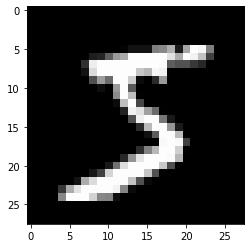

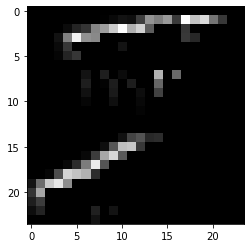

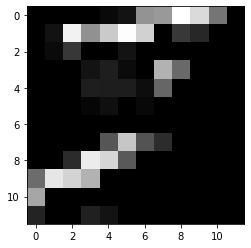

In [30]:
data, _ = load_training_data()
plt.imshow(data[0], cmap='gray')
plt.show()

corelated = sps.correlate2d(data[0], np.random.rand(3, 3) - 0.5, "valid")
corelated = ReLU(corelated)
corelated = sps.correlate2d(corelated, np.random.rand(3, 3) - 0.5, "valid")
corelated = ReLU(corelated)

plt.imshow(corelated, cmap='gray')
plt.show()

width = int(corelated.shape[0] * 0.5)
height = int(corelated.shape[1] * 0.5)
pooled = np.zeros((width, height))

corelated[22:24,22:24]

for i in range(width):
    for j in range(height):
        k = i * 2
        l = j * 2
        pooled[i, j] = np.max(corelated[k:k+2,l:l+2])

plt.imshow(pooled, cmap='gray')
plt.show()